# Logistic Regression Model — `model_logreg.ipynb`

### Description  
This notebook trains, tunes, and evaluates the **final Logistic Regression model** for predicting clinical trial outcomes.  
It uses the **one-hot encoded dataset (`df_final_onehot.csv`)** and optimized hyperparameters derived from earlier experiments.

### Key Steps  
- Load the final one-hot encoded dataset prepared in `9_df_final.ipynb`.  
- Define numeric, categorical, and binary flag features.  
- Split data into training (80%) and testing (20%) sets with stratification.  
- Construct a preprocessing pipeline with:  
  - `StandardScaler` for numeric columns  
  - `Passthrough` for categorical and flag columns  
- Train Logistic Regression using tuned hyperparameters:  
  - **Solver:** `lbfgs`  
  - **Penalty:** `L2`  
  - **C:** `1`  
  - **Class Weight:** `balanced`  
  *(Hyperparameters were finalized based on prior experimental tuning for best balance of interpretability and accuracy.)*  
- Evaluate model performance using accuracy, precision, recall, F1, and ROC-AUC.  
- Compare predictions at two thresholds:  
  - Default (`0.5`)  
  - Optimized **Youden’s J threshold (~0.426)**  
- Visualize confusion matrix, ROC, and Precision–Recall curves.  
- Save model pipeline, metrics, and feature list for deployment.

### Outputs  
- `../models/logreg_pipeline.pkl` → Trained Logistic Regression model  
- `../models/X_cols_logreg.pkl` → Feature list used during training  
- `../results/model_logreg/model_logreg_metrics.csv` → Evaluation summary  
- Confusion matrix, ROC, and PR curve plots in `/results/model_logreg/`

In [1]:
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

In [2]:
# Load Dataset
df_final_onehot = pd.read_csv('../data/final/df_final_onehot.csv', keep_default_na = False)
df_final_onehot.shape

(263136, 79)

In [3]:
target = ['overall_status']
num_features = ['number_of_arms', 'log_enrollment', 'log_duration', 'intervention_count']
flag_features = ['has_dmc','has_expanded_access', 'is_fda_regulated_drug','is_fda_regulated_device', 'has_multiple_intervention_types', 'healthy_volunteers']
extra_feature = ['high_enroll_flag_975']
core_features = df_final_onehot.drop(columns = num_features + extra_feature + flag_features + target)
core_cols = [c for c in core_features if c not in ('nct_id')]

=== Metrics at threshold 0.5 ===
Accuracy : 0.804
Precision: 0.95
Recall   : 0.813
F1       : 0.876
ROC-AUC  : 0.856

Classification Report:
               precision    recall  f1-score   support

           0       0.40      0.75      0.52      7618
           1       0.95      0.81      0.88     45010

    accuracy                           0.80     52628
   macro avg       0.68      0.78      0.70     52628
weighted avg       0.87      0.80      0.83     52628



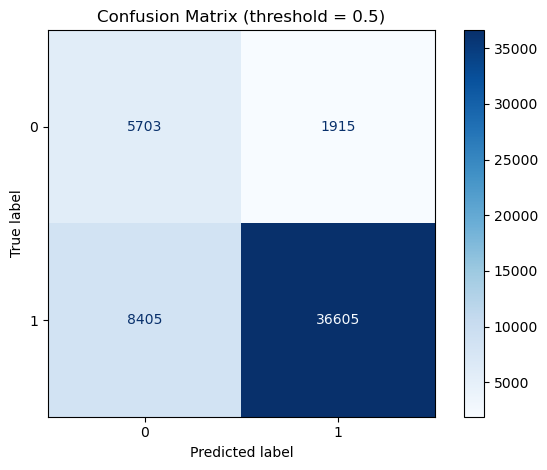

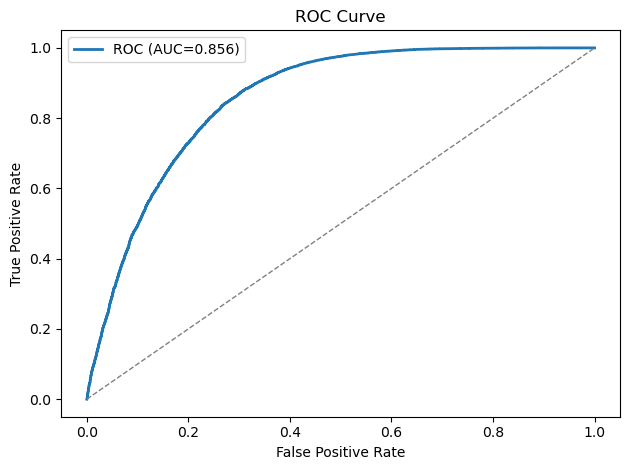

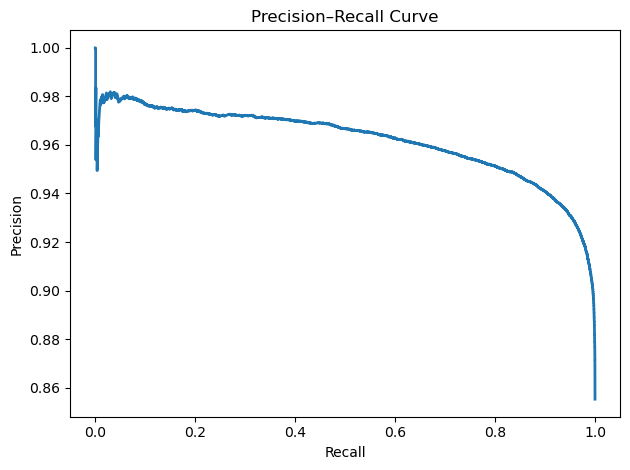


Best threshold by Youden J: 0.426 (J=0.571)

=== Metrics at optimal threshold ===
Accuracy : 0.849
Precision: 0.944
Recall   : 0.875
F1       : 0.908

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.70      0.57      7618
           1       0.94      0.87      0.91     45010

    accuracy                           0.85     52628
   macro avg       0.71      0.79      0.74     52628
weighted avg       0.88      0.85      0.86     52628



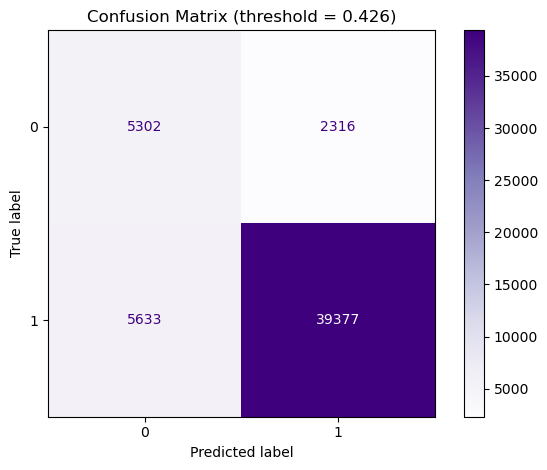


✅ Model, feature list, and metrics saved.


In [4]:
# Logistic Regression – Final Model

# Define features
X = df_final_onehot[num_features + core_cols + flag_features + extra_feature]
y = df_final_onehot['overall_status']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing + Model Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', 'passthrough', core_cols)
    ], remainder='drop'
)

logreg = Pipeline(steps=[
    ('pre', preprocessor),
    ('clf', LogisticRegression(
        solver='lbfgs', penalty='l2', C=1,
        class_weight='balanced', max_iter=1000, random_state=42
    ))
])

# Train Model
logreg.fit(X_train, y_train)

# Predict with default threshold (0.5)
y_prob = logreg.predict_proba(X_test)[:, 1]
y_pred = (y_prob >= 0.5).astype(int)

# Evaluation metrics
print("=== Metrics at threshold 0.5 ===")
print("Accuracy :", round(accuracy_score(y_test, y_pred), 3))
print("Precision:", round(precision_score(y_test, y_pred), 3))
print("Recall   :", round(recall_score(y_test, y_pred), 3))
print("F1       :", round(f1_score(y_test, y_pred), 3))
print("ROC-AUC  :", round(roc_auc_score(y_test, y_prob), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Save classification report
with open("../results/model_logreg/logreg_classification_report_default.txt", "w") as f:
    f.write(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (threshold = 0.5)")
plt.tight_layout()
plt.savefig('../results/model_logreg/logreg_confusion_matrix_default.png', dpi = 200)
plt.show()

# ROC Curve
fpr, tpr, roc_th = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, lw=2, label=f"ROC (AUC={roc_auc_score(y_test, y_prob):.3f})")
plt.plot([0, 1], [0, 1], "--", lw=1, color="grey")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve"); plt.legend()
plt.tight_layout()
plt.savefig('../results/model_logreg/logreg_roc_curve.png', dpi = 200)
plt.show()

# Precision–Recall Curve
prec, rec, pr_th = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(rec, prec, lw=2)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout()
plt.savefig('../results/model_logreg/logreg_precision_recall_curve.png', dpi = 200)
plt.show()

# Optimal Threshold – Youden’s J
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_thr = roc_th[best_idx]

print(f"\nBest threshold by Youden J: {best_thr:.3f} (J={j_scores[best_idx]:.3f})")
y_pred_opt = (y_prob >= best_thr).astype(int)

print("\n=== Metrics at optimal threshold ===")
print("Accuracy :", round(accuracy_score(y_test, y_pred_opt), 3))
print("Precision:", round(precision_score(y_test, y_pred_opt), 3))
print("Recall   :", round(recall_score(y_test, y_pred_opt), 3))
print("F1       :", round(f1_score(y_test, y_pred_opt), 3))
print("\nClassification Report:\n", classification_report(y_test, y_pred_opt))

# Save classification report
with open("../results/model_logreg/logreg_classification_report_optimal.txt", "w") as f:
    f.write(classification_report(y_test, y_pred_opt))

cm_opt = confusion_matrix(y_test, y_pred_opt)
ConfusionMatrixDisplay(cm_opt).plot(cmap="Purples", values_format="d")
plt.title(f"Confusion Matrix (threshold = {best_thr:.3f})")
plt.tight_layout()
plt.savefig('../results/model_logreg/logreg_confusion_matrix_optimal.png', dpi = 200)
plt.show()

# Save model and metrics
joblib.dump(logreg, "../models/logreg_pipeline.pkl")

# Save feature columns
joblib.dump(X.columns.tolist(), "../models/X_cols_logreg.pkl")

# Save metrics
metrics = {
    "Accuracy_0.5": round(accuracy_score(y_test, y_pred), 3),
    "Precision_0.5": round(precision_score(y_test, y_pred), 3),
    "Recall_0.5": round(recall_score(y_test, y_pred), 3),
    "F1_0.5": round(f1_score(y_test, y_pred), 3),
    "ROC_AUC": round(roc_auc_score(y_test, y_prob), 3),
    "Best_threshold": round(best_thr, 3),
    "Accuracy_opt": round(accuracy_score(y_test, y_pred_opt), 3),
    "Precision_opt": round(precision_score(y_test, y_pred_opt), 3),
    "Recall_opt": round(recall_score(y_test, y_pred_opt), 3),
    "F1_opt": round(f1_score(y_test, y_pred_opt), 3)
}

pd.DataFrame([metrics]).to_csv("../results/model_logreg/model_logreg_metrics.csv", index=False)

print("\n✅ Model, feature list, and metrics saved.")


---

## Summary  
The Logistic Regression model with **LBFGS solver**, **L2 penalty**, and **C=1** achieved strong and interpretable baseline performance.  

Key results:  
- **Default threshold (0.5):**  
  - Accuracy: **0.801**  
  - Precision: **0.894**  
  - Recall: **0.813**  
  - F1: **0.876**  
  - ROC-AUC: **0.856**  

- **Youden’s J optimized threshold (~0.426):**  
  - Accuracy: **0.849**  
  - Precision: **0.944**  
  - Recall: **0.875**  
  - F1: **0.908**  

Using Youden’s J threshold improved the **balance between sensitivity and specificity**,  
resulting in a more reliable predictor for identifying both successful and failed trials.  

---

📂 **Next Notebook:** `model_xgb.ipynb` → Builds and evaluates the XGBoost model for comparative performance analysis.

